# Fase 1: Preparación de los datos

## Importación de Librerías y Configuración

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para guardar el scaler y modelos clásicos
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import os

# Para Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## Carga de Datos

In [43]:
# Definir nombres de columnas genéricos para TEP (52 variables)
def load_tep_data(fault_range=range(0, 22), data_dir='../data/TEP_csv'):
    """
    Carga los archivos CSV del Tennessee Eastman Process.
    
    Args:
        fault_range: Rango de fallos a cargar (0 = normal, 1-21 = fallos)
        data_dir: Directorio con archivos CSV
    
    Returns:
        df_train, df_test: DataFrames de entrenamiento y prueba
    """
    train_data = []
    test_data = []
    
    print("="*60)
    print("CARGANDO DATOS TENNESSEE EASTMAN PROCESS")
    print("="*60)
    
    for fault_id in fault_range:
        file_id = f"{fault_id:02d}"
        train_file = f"d{file_id}.csv"
        test_file = f"d{file_id}_te.csv"
        
        path_train = os.path.join(data_dir, train_file)
        path_test = os.path.join(data_dir, test_file)
        
        # Cargar Train
        if os.path.exists(path_train):
            df_tr = pd.read_csv(path_train)
            train_data.append(df_tr)
            print(f"✓ Train: {train_file:15} | Shape: {df_tr.shape}")
            
        # Cargar Test
        if os.path.exists(path_test):
            df_te = pd.read_csv(path_test)
            test_data.append(df_te)
            print(f"✓ Test:  {test_file:15} | Shape: {df_te.shape}")
    
    # Concatenar todo
    df_train_final = pd.concat(train_data, ignore_index=True)
    df_test_final = pd.concat(test_data, ignore_index=True)
    
    print("="*60)
    print(f"TOTAL Train: {df_train_final.shape}")
    print(f"TOTAL Test:  {df_test_final.shape}")
    print("="*60)
    
    return df_train_final, df_test_final

# --- EJECUCIÓN DE CARGA ---
# Asumiendo que los archivos están en la misma carpeta que el notebook
# Si usas Colab, sube los archivos y ajusta la ruta si es necesario.
df_train, df_test = load_tep_data() # Solo cargamos fallos 0 a 4 por ahora

print("\nTotal Train:", df_train.shape)
print("Total Test:", df_test.shape)

CARGANDO DATOS TENNESSEE EASTMAN PROCESS
✓ Train: d00.csv         | Shape: (52, 54)
✓ Test:  d00_te.csv      | Shape: (960, 54)
✓ Train: d01.csv         | Shape: (480, 54)
✓ Test:  d01_te.csv      | Shape: (960, 54)
✓ Train: d02.csv         | Shape: (480, 54)
✓ Test:  d02_te.csv      | Shape: (960, 54)
✓ Train: d03.csv         | Shape: (480, 54)
✓ Test:  d03_te.csv      | Shape: (960, 54)
✓ Train: d04.csv         | Shape: (480, 54)
✓ Test:  d04_te.csv      | Shape: (960, 54)
✓ Train: d05.csv         | Shape: (480, 54)
✓ Test:  d05_te.csv      | Shape: (960, 54)
✓ Train: d06.csv         | Shape: (480, 54)
✓ Test:  d06_te.csv      | Shape: (960, 54)
✓ Train: d07.csv         | Shape: (480, 54)
✓ Test:  d07_te.csv      | Shape: (960, 54)
✓ Train: d08.csv         | Shape: (480, 54)
✓ Test:  d08_te.csv      | Shape: (960, 54)
✓ Train: d09.csv         | Shape: (480, 54)
✓ Test:  d09_te.csv      | Shape: (960, 54)
✓ Train: d10.csv         | Shape: (480, 54)
✓ Test:  d10_te.csv      | Shape: (9

## Exploración inicial

In [45]:
print("\n📊 INFORMACIÓN DEL DATASET DE ENTRENAMIENTO")
print(df_train.info())
print("\n📊 PRIMERAS FILAS:")
print(df_train.head())

print("\n📊 DISTRIBUCIÓN DE FALLOS (Train):")
print(df_train['fault_type'].value_counts().sort_index())

print("\n📊 DISTRIBUCIÓN DE FALLOS (Test):")
print(df_test['fault_type'].value_counts().sort_index())

print("\n📊 VERIFICACIÓN - Primeras muestras de cada tipo:")
for fault_id in range(min(5, df_train['fault'].max() + 1)):
    sample = df_train[df_train['fault'] == fault_id].head(2)
    print(f"\nFault {fault_id} ({sample['fault_type'].iloc[0]}):")
    print(f"  Muestras: {len(df_train[df_train['fault'] == fault_id])}")


📊 INFORMACIÓN DEL DATASET DE ENTRENAMIENTO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10132 entries, 0 to 10131
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   A_Feed_stream1               10132 non-null  float64
 1   D_Feed_stream2               10132 non-null  float64
 2   E_Feed_stream3               10132 non-null  float64
 3   AC_Feed_stream4              10132 non-null  float64
 4   Recycle_Flow_stream8         10132 non-null  float64
 5   Reactor_Feed_Rate_stream6    10132 non-null  float64
 6   Reactor_Pressure             10132 non-null  float64
 7   Reactor_Level                10132 non-null  float64
 8   Reactor_Temperature          10132 non-null  float64
 9   Purge_Rate_stream9           10132 non-null  float64
 10  Product_Sep_Temp             10132 non-null  float64
 11  Product_Sep_Level            10132 non-null  float64
 12  Prod_Sep_Pressure            1

## Limpieza y Normalización

In [46]:
# 1. Verificar columnas
print("📊 COLUMNAS DISPONIBLES:")
print(df_train.columns.tolist())

# 2. Separar Features (X) y Target (y)
# Eliminar columnas de identificación/target
columns_to_drop = ['sample', 'fault', 'fault_type']
# Solo eliminar las que existan
columns_to_drop = [col for col in columns_to_drop if col in df_train.columns]

print(f"\n🗑️ ELIMINANDO COLUMNAS: {columns_to_drop}")

X_train = df_train.drop(columns_to_drop, axis=1)
X_test = df_test.drop(columns_to_drop, axis=1)

# Target: usar la columna numérica 'fault'
y_train = df_train['fault']
y_test = df_test['fault']

feature_names = X_train.columns.tolist()

print(f"\n✓ Features: {X_train.shape[1]}")
print(f"✓ Train samples: {X_train.shape[0]}")
print(f"✓ Test samples: {X_test.shape[0]}")
print(f"✓ Clases únicas: {sorted(y_train.unique())}")
print(f"✓ Número de clases: {len(y_train.unique())}")

# Verificar que todo sea numérico
non_numeric = X_train.select_dtypes(include=['object']).columns.tolist()
if len(non_numeric) > 0:
    print(f"\n⚠️ ADVERTENCIA: Columnas no numéricas: {non_numeric}")
else:
    print("\n✓ Todas las features son numéricas")

# 3. Normalización (StandardScaler)
print("\n🔧 APLICANDO NORMALIZACIÓN...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler
joblib.dump(scaler, 'tep_scaler.pkl')
print("✓ Scaler guardado: tep_scaler.pkl")

# Convertir a DataFrame para EDA (con nombres correctos)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_train_df['fault'] = y_train.values  # Añadir columna numérica de fault

print(f"\n✓ Shape X_train_scaled: {X_train_scaled.shape}")
print(f"✓ Shape X_test_scaled:  {X_test_scaled.shape}")
print(f"✓ Shape X_train_df:     {X_train_df.shape}")

# Verificar balanceo de clases
print("\n📊 BALANCEO DE CLASES:")
class_counts = y_train.value_counts().sort_index()
for fault_id, count in class_counts.items():
    percentage = (count / len(y_train)) * 100
    fault_name = 'Normal' if fault_id == 0 else f'Fault_{fault_id}'
    print(f"  {fault_name:15}: {count:6} muestras ({percentage:5.2f}%)")

📊 COLUMNAS DISPONIBLES:
['A_Feed_stream1', 'D_Feed_stream2', 'E_Feed_stream3', 'AC_Feed_stream4', 'Recycle_Flow_stream8', 'Reactor_Feed_Rate_stream6', 'Reactor_Pressure', 'Reactor_Level', 'Reactor_Temperature', 'Purge_Rate_stream9', 'Product_Sep_Temp', 'Product_Sep_Level', 'Prod_Sep_Pressure', 'Prod_Sep_Underflow_stream10', 'Stripper_Level', 'Stripper_Pressure', 'Stripper_Underflow_stream11', 'Stripper_Temperature', 'Stripper_Steam_Flow', 'Compressor_Work', 'Reactor_CW_Outlet_Temp', 'Separator_CW_Outlet_Temp', 'Reactor_Feed_CompA', 'Reactor_Feed_CompB', 'Reactor_Feed_CompC', 'Reactor_Feed_CompD', 'Reactor_Feed_CompE', 'Reactor_Feed_CompF', 'Purge_Gas_CompA', 'Purge_Gas_CompB', 'Purge_Gas_CompC', 'Purge_Gas_CompD', 'Purge_Gas_CompE', 'Purge_Gas_CompF', 'Purge_Gas_CompG', 'Purge_Gas_CompH', 'Product_CompD', 'Product_CompE', 'Product_CompF', 'Product_CompG', 'Product_CompH', 'D_Feed_Flow', 'E_Feed_Flow', 'A_Feed_Flow', 'AC_Feed_Flow', 'Compressor_Recycle_Valve', 'Purge_Valve', 'Separator_

## EDA y Selección de Variables (PCA)

### 4.1 Distribución de Clases


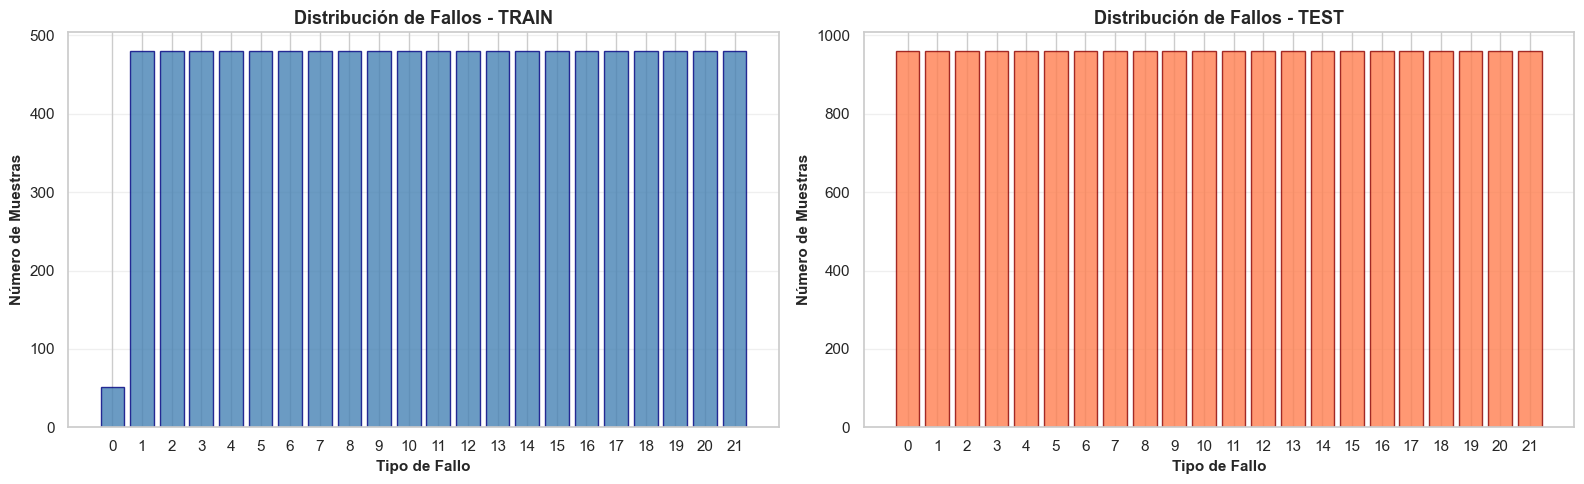

✓ Distribución de clases visualizada


In [47]:
# Visualizar distribución
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Train
train_counts = y_train.value_counts().sort_index()
axes[0].bar(train_counts.index, train_counts.values, color='steelblue', alpha=0.8, edgecolor='navy')
axes[0].set_xlabel('Tipo de Fallo', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Número de Muestras', fontsize=11, fontweight='bold')
axes[0].set_title('Distribución de Fallos - TRAIN', fontsize=13, fontweight='bold')
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].set_xticks(range(0, len(train_counts)))

# Test
test_counts = y_test.value_counts().sort_index()
axes[1].bar(test_counts.index, test_counts.values, color='coral', alpha=0.8, edgecolor='darkred')
axes[1].set_xlabel('Tipo de Fallo', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Número de Muestras', fontsize=11, fontweight='bold')
axes[1].set_title('Distribución de Fallos - TEST', fontsize=13, fontweight='bold')
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].set_xticks(range(0, len(test_counts)))

plt.tight_layout()
plt.savefig('distribucion_clases.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribución de clases visualizada")

### 4.2 Matriz de Correlación


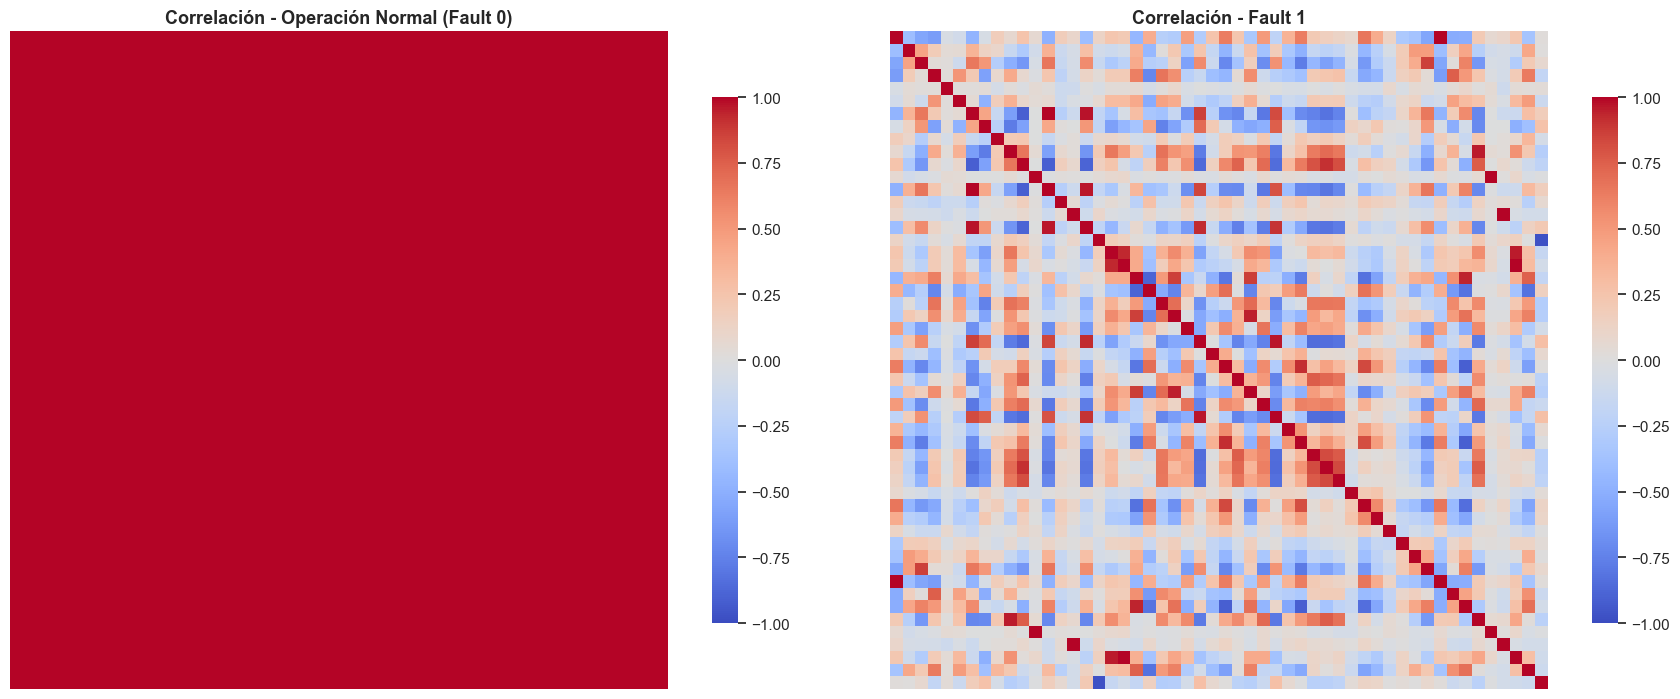

✓ Matriz de correlación generada


In [48]:
# Matriz de Correlación (Normal vs Fault 1)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Subset Normal (Fault 0)
subset_normal = X_train_df[X_train_df['fault'] == 0].drop('fault', axis=1)
corr_normal = subset_normal.corr()

sns.heatmap(corr_normal, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, ax=axes[0],
            cbar_kws={"shrink": 0.8}, xticklabels=False, yticklabels=False)
axes[0].set_title('Correlación - Operación Normal (Fault 0)', 
                  fontsize=13, fontweight='bold')

# Subset Fault 1
subset_fault1 = X_train_df[X_train_df['fault'] == 1].drop('fault', axis=1)
corr_fault1 = subset_fault1.corr()

sns.heatmap(corr_fault1, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1],
            cbar_kws={"shrink": 0.8}, xticklabels=False, yticklabels=False)
axes[1].set_title('Correlación - Fault 1', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de correlación generada")

### 4.3 Visualización PCA

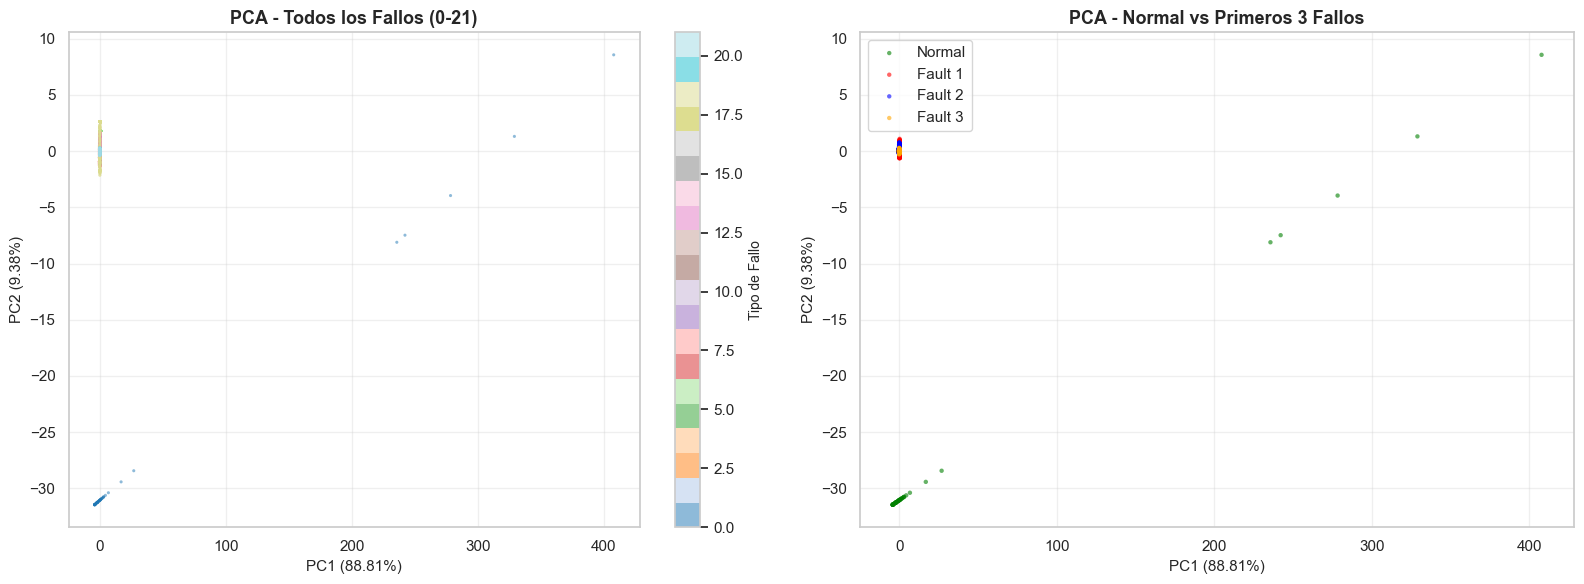

✓ Varianza explicada (2D): 98.19%


In [49]:
# PCA para visualización (2 componentes)
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_train_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Todos los fallos
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=y_train, cmap='tab20', 
                           alpha=0.5, s=5, edgecolors='none')
axes[0].set_title('PCA - Todos los Fallos (0-21)', fontsize=13, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.2%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.2%})', fontsize=11)
cbar = plt.colorbar(scatter1, ax=axes[0])
cbar.set_label('Tipo de Fallo', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Solo Normal vs primeros 3 fallos
colors = ['green', 'red', 'blue', 'orange']
labels = ['Normal', 'Fault 1', 'Fault 2', 'Fault 3']

for fault_id, color, label in zip(range(4), colors, labels):
    mask = y_train == fault_id
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=color, label=label, alpha=0.6, s=10, edgecolors='none')

axes[1].set_title('PCA - Normal vs Primeros 3 Fallos', fontsize=13, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.2%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.2%})', fontsize=11)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_visualizacion.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Varianza explicada (2D): {np.sum(pca_viz.explained_variance_ratio_):.2%}")

## Feature Engineering (Ventanas de Tiempo para LSTM)

In [51]:
def create_sequences(X, y, time_steps=10):
    """
    Transforma datos 2D (muestras, features) a 3D (muestras, time_steps, features)
    """
    Xs, ys = [], []
    # Recorremos el array creando ventanas
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Usamos una ventana de 10 muestras anteriores

# Creamos las secuencias (Esto puede tardar un poco si hay muchos datos)
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

# One-hot encoding de las etiquetas para la red neuronal
num_classes = len(np.unique(y_train))
y_train_lstm_cat = to_categorical(y_train_lstm, num_classes=num_classes)
y_test_lstm_cat = to_categorical(y_test_lstm, num_classes=num_classes)

print(f"Shape para LSTM (Train): {X_train_lstm.shape}")
# Resultado esperado: (n_muestras, 10, 52)

Shape para LSTM (Train): (10122, 10, 52)


## Entrenamiento de Modelos y Comparativa

### Modelo 1: Random Forest

In [ ]:
print("Entrenando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)


# Evaluación RF
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Reporte Random Forest ---")
print(classification_report(y_test, y_pred_rf))


# Guardar Modelo RF
joblib.dump(rf_model, 'tep_rf_model.pkl')

Entrenando Random Forest...

--- Reporte Random Forest ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       960
           1       0.99      0.82      0.90       960
           2       0.98      0.81      0.89       960
           3       0.11      0.21      0.14       960
           4       0.93      0.80      0.86       960
           5       0.60      0.52      0.56       960
           6       1.00      0.83      0.91       960
           7       1.00      0.83      0.91       960
           8       0.73      0.51      0.60       960
           9       0.12      0.18      0.14       960
          10       0.28      0.38      0.32       960
          11       0.83      0.56      0.67       960
          12       0.51      0.63      0.56       960
          13       0.82      0.18      0.30       960
          14       0.95      0.79      0.86       960
          15       0.10      0.29      0.14       960
          16       0.3

/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1

['tep_rf_model.pkl']

### Modelo 2: LSTM

In [56]:
print("Entrenando LSTM...")

model_lstm = Sequential()
# Capa LSTM
model_lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model_lstm.add(Dropout(0.2)) # Para evitar sobreajuste
# Capa densa de salida
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar (usamos pocas epochs para prueba rápida, sube a 10-20 para resultado real)
history = model_lstm.fit(
    X_train_lstm, y_train_lstm_cat,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Guardar Modelo LSTM (formato nuevo de keras)
model_lstm.save('tep_lstm_model.keras')
print("Modelo LSTM guardado.")

Entrenando LSTM...
Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2596 - loss: 2.4741 - val_accuracy: 0.0000e+00 - val_loss: 6.9405
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3969 - loss: 1.8299 - val_accuracy: 0.0000e+00 - val_loss: 7.3459
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4746 - loss: 1.5815 - val_accuracy: 0.0000e+00 - val_loss: 8.7792
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5439 - loss: 1.4023 - val_accuracy: 0.0039 - val_loss: 8.6623
Epoch 5/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5825 - loss: 1.2772 - val_accuracy: 0.0000e+00 - val_loss: 9.2086
Epoch 6/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6135 - loss: 1.1838 - val_accuracy: 0.0000e+00 - val_loss: 9.6618
Epoch 7/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6295 - loss: 1.1157 - val_accuracy: 0.0128 - val_loss: 9.3131
Epoch 8/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

## Evaluación y Matriz de Confusión

660/660 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step


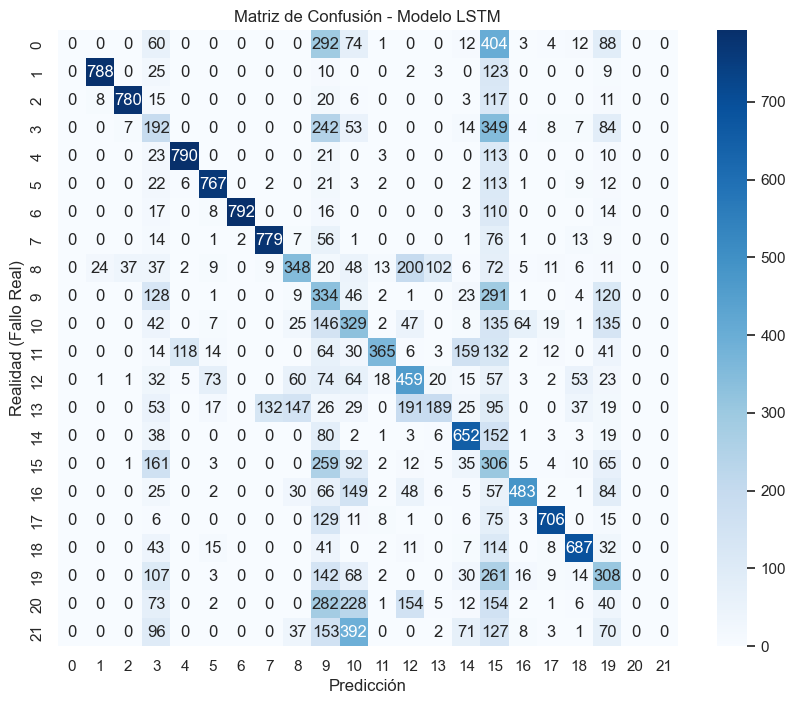

F1-Score Random Forest: 0.5578
F1-Score LSTM: 0.4861


In [57]:
# Predicciones LSTM
y_pred_lstm_prob = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

# Matriz de Confusión (Usando LSTM como ejemplo principal)
cm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Realidad (Fallo Real)")
plt.show()

# Comparativa rápida
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print(f"F1-Score Random Forest: {f1_rf:.4f}")
print(f"F1-Score LSTM: {f1_lstm:.4f}")